In [1]:
!pip install pmdarima

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
train = pd.read_csv(r"/NSE Training Data - 1st Jan 2016 to 1st Jan 2022.csv"
                 , index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)
train.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,7924.549805,7937.549805,7781.100098,7791.299805,7791.299805,134700.0
2016-01-05,7828.399902,7831.200195,7763.250000,7784.649902,7784.649902,145200.0
2016-01-06,7788.049805,7800.950195,7721.200195,7741.000000,7741.000000,147100.0
2016-01-07,7673.350098,7674.950195,7556.600098,7568.299805,7568.299805,188900.0
2016-01-08,7611.649902,7634.100098,7581.049805,7601.350098,7601.350098,157400.0


In [8]:
test=pd.read_csv(r"/NSE Out of Time Testing Data - 1st Jan 2022 to 4th Feb 2022.csv"
                 , index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)
test.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-03,17387.150391,17646.650391,17383.300781,17625.699219,17625.699219,200500
2022-01-04,17681.400391,17827.599609,17593.550781,17805.250000,17805.250000,247400
2022-01-05,17820.099609,17944.699219,17748.849609,17925.250000,17925.250000,251500
2022-01-06,17768.500000,17797.949219,17655.550781,17745.900391,17745.900391,236500
2022-01-07,17797.599609,17905.000000,17704.550781,17812.699219,17812.699219,239300


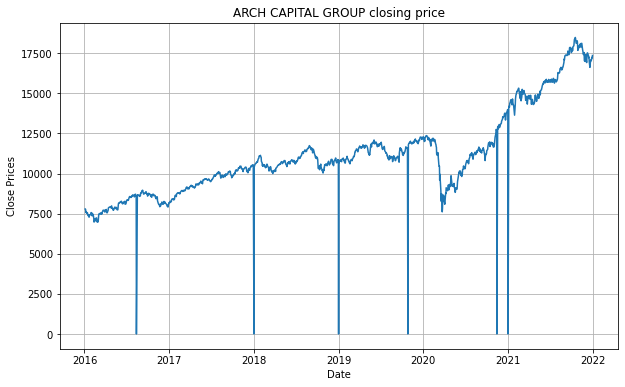

In [9]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(train['Close'])
plt.title('ARCH CAPITAL GROUP closing price')
plt.show()

In [10]:
train.Close.value_counts()

0.000000        6
11669.150391    2
11844.099609    2
11278.900391    2
10167.450195    2
               ..
10531.500000    1
10493.000000    1
10440.299805    1
10444.200195    1
17354.050781    1
Name: Close, Length: 1460, dtype: int64

In [11]:
train['Close']=train['Close'].replace(0,train['Close'].mean())

In [12]:
train['Close'].value_counts()

11134.930215    6
11669.150391    2
11844.099609    2
11278.900391    2
10167.450195    2
               ..
10531.500000    1
10493.000000    1
10440.299805    1
10444.200195    1
17354.050781    1
Name: Close, Length: 1460, dtype: int64

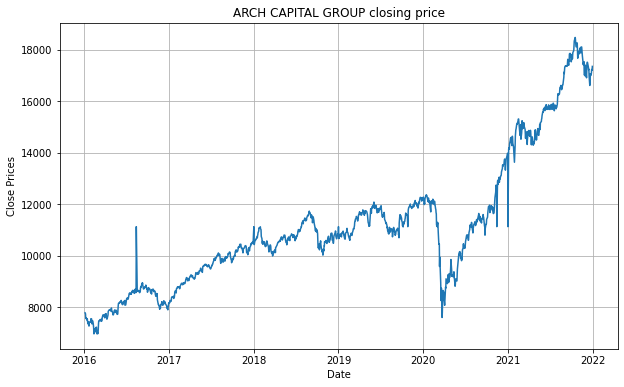

In [13]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(train['Close'])
plt.title('ARCH CAPITAL GROUP closing price')
plt.show()

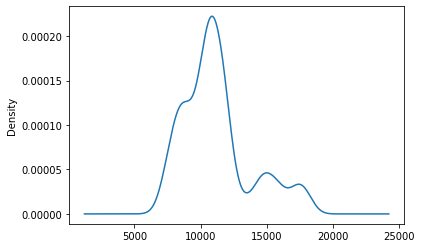

In [14]:
#Distribution of the dataset
df_close =train['Close']
df_close.plot(kind='kde')

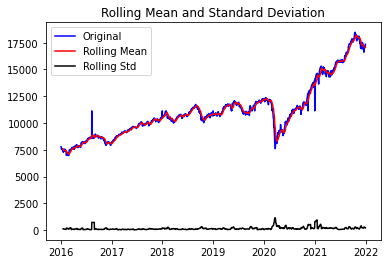

Results of dickey fuller test
Test Statistics                   0.159319
p-value                           0.969885
No. of lags used                  3.000000
Number of observations used    1477.000000
critical value (1%)              -3.434785
critical value (5%)              -2.863499
critical value (10%)             -2.567813
dtype: float64


In [15]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

<Figure size 432x288 with 0 Axes>

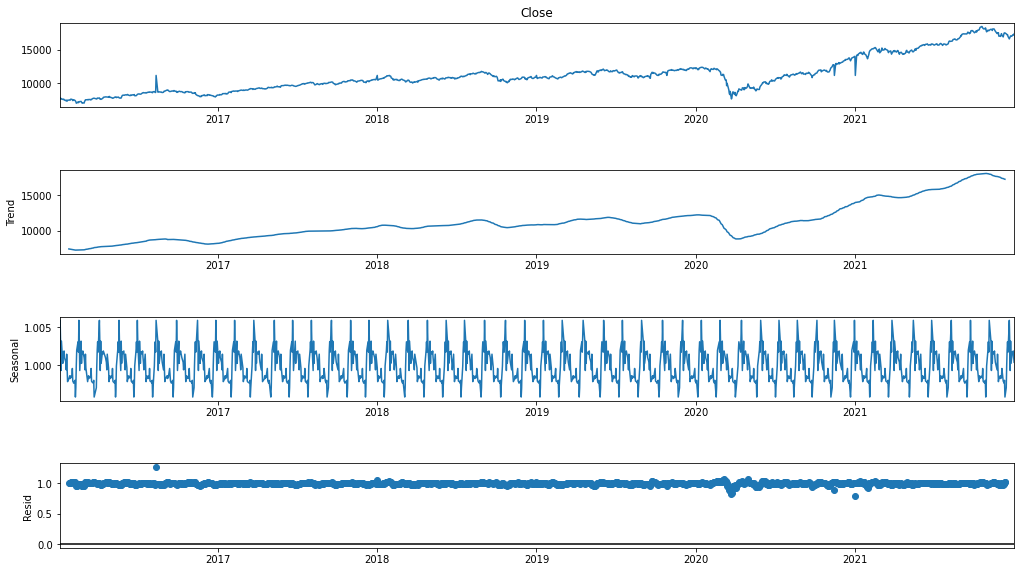

In [23]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


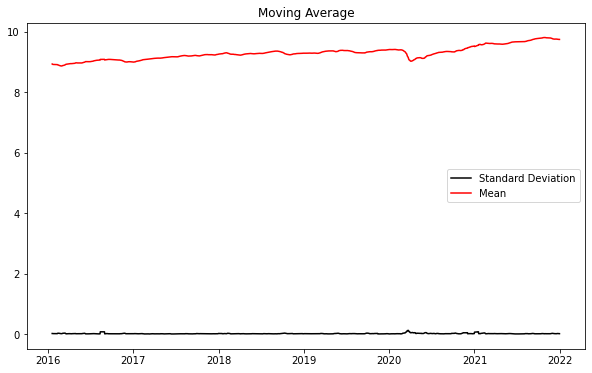

In [24]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

In [25]:
train_data=df_log

#Distribution of the dataset
df_close1 =test['Close']
df_log1 = np.log(df_close1)

test_data=df_log1

print("Train shape",train_data.shape)
print("Test shape",test_data.shape)

Train shape (1481,)
Test shape (23,)


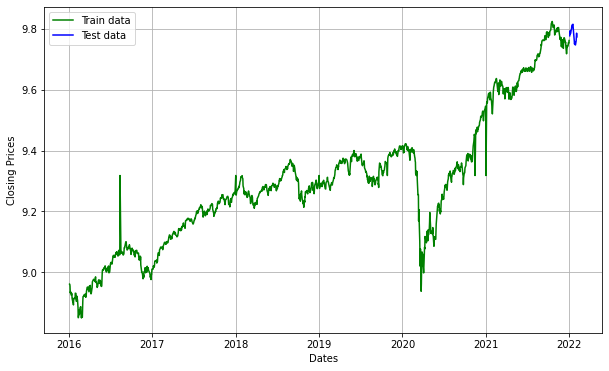

In [26]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7684.984, Time=0.76 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7835.335, Time=0.92 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-7857.844, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7685.650, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-7855.430, Time=0.97 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-7855.918, Time=1.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-7853.868, Time=1.61 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-7856.283, Time=0.23 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 6.691 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1481
Model:               SARIMAX(0, 1, 1)   Log Likelihood                3931.922
Date:                Tue, 08 Feb 2022   AIC                          -7857.844
Time:                       

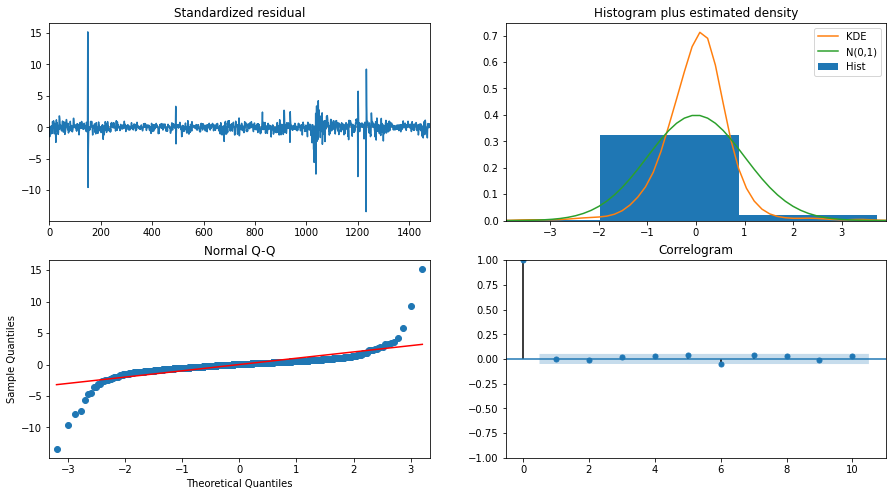

In [27]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [39]:
#Modeling
# Build Model
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data, order=(0,1,1))  
fitted = model.fit()  
print(fitted.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1481
Model:                 ARIMA(0, 1, 1)   Log Likelihood                3930.142
Date:                Tue, 08 Feb 2022   AIC                          -7856.283
Time:                        03:59:16   BIC                          -7845.684
Sample:                             0   HQIC                         -7852.332
                               - 1481                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3533      0.005    -66.228      0.000      -0.364      -0.343
sigma2         0.0003   1.88e-06    154.115      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [48]:
fc = fitted.forecast(23, alpha=0.05)  # 95% conf

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:393: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [49]:
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.0010860588025596379
MAE: 0.028486507036527057
RMSE: 0.03295540627210713
MAPE: nan
